weather_type            1.000000
uv_index                0.345804
season                  0.118791
location                0.071665
visibility_(km)         0.047448
atmospheric_pressure    0.030679
temperature             0.028923
precipitation_(%)      -0.161578
wind_speed             -0.166485
humidity               -0.250558
cloud_cover            -0.536681
Name: weather_type, dtype: float64


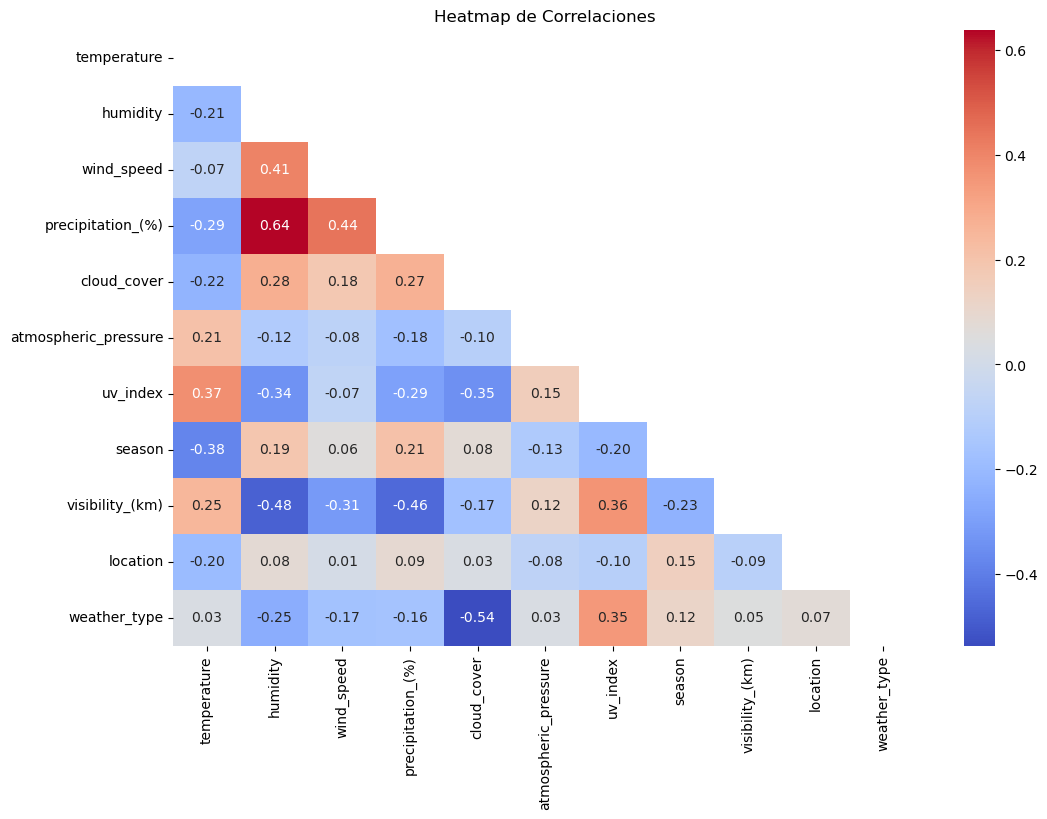

In [81]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
from sklearn.preprocessing import LabelBinarizer

# Cargar los datos
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Preprocesar los datos
# Codificar variables categóricas
label_encoder = LabelEncoder()
data['weather_type'] = label_encoder.fit_transform(data['weather_type'])
data['cloud_cover'] = label_encoder.fit_transform(data['cloud_cover'])
data['season'] = label_encoder.fit_transform(data['season'])
data['location'] = label_encoder.fit_transform(data['location'])

# Do dummies for categorical variables
# data = pd.get_dummies(data, columns=['location', 'season', 'cloud_cover'])

target = 'weather_type'

# Mostrar la correlación entre las características y el objetivo
correlation = data.corr()
print(correlation[target].sort_values(ascending=False))

# Reorganizar las columnas para que la variable objetivo esté al final
columns = [col for col in correlation.columns if col != target] + [target]
correlation = correlation[columns].loc[columns]

# Visualizar el heatmap de correlaciones
plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(correlation, dtype=bool))
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', mask=mask)
plt.title('Heatmap de Correlaciones')
plt.show()

In [83]:
# Separar características y etiquetas
X = data.drop(target, axis=1)
y = data[target]

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_standarized = scaler.fit_transform(X_train)
X_test_standarized = scaler.transform(X_test)

# Ajustar los parámetros del Random Forest
param_grid = {
    'n_estimators': [15, 20],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# param_grid = {
#     'n_estimators': [150, 200],
#     'max_features': ['sqrt', 'log2'],
#     'max_depth': [15, 20, None],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2],
#     'bootstrap': [True, False]
# }

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_standarized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_standarized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_standarized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
89 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-package

Accuracy: 0.915530303030303
Best Parameters: {'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [84]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.91      0.90       651
           1       0.90      0.90      0.90       647
           2       0.93      0.94      0.93       701
           3       0.94      0.90      0.92       641

    accuracy                           0.92      2640
   macro avg       0.92      0.91      0.92      2640
weighted avg       0.92      0.92      0.92      2640



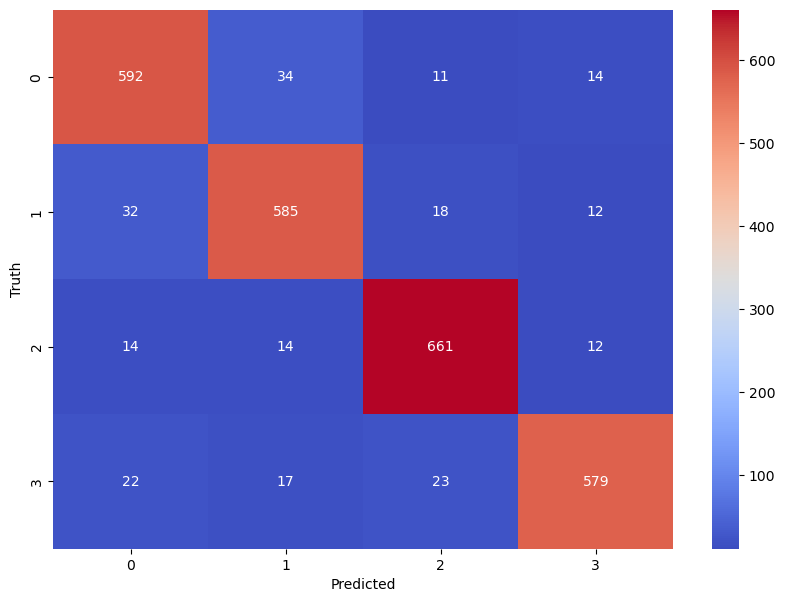

In [85]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()


## Con métricas reales de estación meteorológica (con estandarización)

In [86]:
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
data = data.drop(['season', 'location', 'cloud_cover'], axis=1)

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Estandarizar los datos
scaler = StandardScaler()
X_train_standarized = scaler.fit_transform(X_train)
X_test_standarized = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_standarized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_standarized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_standarized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-package

Accuracy: 0.9049242424242424
Best Parameters: {'bootstrap': True, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20}


## Con métricas reales de estación meteorológica (con normalización)

In [87]:
# Load the data
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
# data = data.drop(['season', 'location', 'cloud_cover'], axis=1)
data = data.drop(['cloud_cover'], axis=1)

# Do dummies for season and location
data = pd.get_dummies(data, columns=['season', 'location'])

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_normalized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_normalized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_normalized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
77 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-package

Accuracy: 0.9026515151515152
Best Parameters: {'bootstrap': False, 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}


In [89]:
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))

Accuracy: 0.90
              precision    recall  f1-score   support

      Cloudy       0.89      0.87      0.88       651
       Rainy       0.90      0.91      0.91       647
       Snowy       0.94      0.94      0.94       701
       Sunny       0.89      0.90      0.89       641

    accuracy                           0.90      2640
   macro avg       0.90      0.90      0.90      2640
weighted avg       0.90      0.90      0.90      2640



## The ROC Curve

Fitting 3 folds for each of 96 candidates, totalling 288 fits


c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
144 fits failed out of a total of 288.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
89 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\jesus\anaconda3\Lib\site-packages\sklearn\base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\jesus\anaconda3\Lib\site-package

Accuracy: 0.9049242424242424
Best Parameters: {'bootstrap': False, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 15}


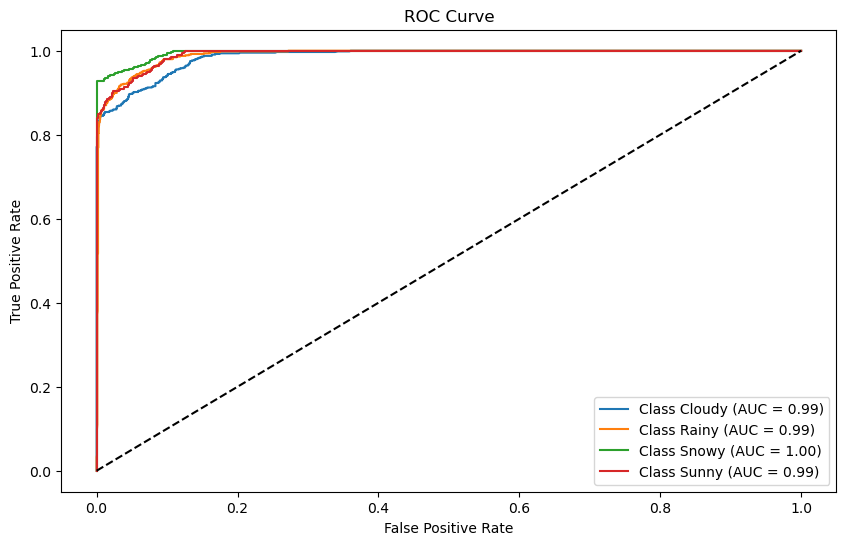

In [88]:
# Load the data
data = pd.read_csv('../data/processed/weather_classification_data.csv')

# Drop meaningless columns
data = data.drop(['season', 'location', 'cloud_cover'], axis=1)

# Separar características y etiquetas
X = data.drop('weather_type', axis=1)
y = data['weather_type']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar los datos
scaler = MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

# Realizar la búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_normalized, y_train)

# Entrenar el modelo con los mejores parámetros
best_params = grid_search.best_params_
rnd_clf = RandomForestClassifier(**best_params)
rnd_clf.fit(X_train_normalized, y_train)

# Predecir
y_pred = rnd_clf.predict(X_test_normalized)

# Evaluar
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(f'Best Parameters: {best_params}')

# Binarizar las etiquetas para calcular la ROC Curve para cada clase
lb = LabelBinarizer()
y_test_binarized = lb.fit_transform(y_test)
y_prob = rnd_clf.predict_proba(X_test_normalized)

# Calcular y graficar la ROC Curve para cada clase
plt.figure(figsize=(10, 6))
for i in range(y_test_binarized.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_prob[:, i])
    auc = roc_auc_score(y_test_binarized[:, i], y_prob[:, i])
    plt.plot(fpr, tpr, label=f'Class {lb.classes_[i]} (AUC = {auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()